In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

## Dataset

### Load Dataset(From 9 Environments)

In [1]:
import pandas as pd
from pathlib import Path

# -----------------------------
# File Paths & Column Settings
# -----------------------------
MOTION_FILES = [
    "datasets/090_Tm_7.5_HS_3.5.out",
    "datasets/090_Tm_9.5_HS_3.5.out",
    "datasets/090_Tm_11.5_HS_3.5.out",
    "datasets/135_Tm_7.5_HS_3.5.out",
    "datasets/135_Tm_9.5_HS_3.5.out",
    "datasets/135_Tm_11.5_HS_3.5.out",
    "datasets/180_Tm_7.5_HS_3.5.out",
    "datasets/180_Tm_9.5_HS_3.5.out",
    "datasets/180_Tm_11.5_HS_3.5.out"
]

WAVE_FILES = [
    "datasets/Wave_090_Tm_7.5_HS_3.5.out",
    "datasets/Wave_090_Tm_9.5_HS_3.5.out",
    "datasets/Wave_090_Tm_11.5_HS_3.5.out",
    "datasets/Wave_135_Tm_7.5_HS_3.5.out",
    "datasets/Wave_135_Tm_9.5_HS_3.5.out",
    "datasets/Wave_135_Tm_11.5_HS_3.5.out",
    "datasets/Wave_180_Tm_7.5_HS_3.5.out",
    "datasets/Wave_180_Tm_9.5_HS_3.5.out",
    "datasets/Wave_180_Tm_11.5_HS_3.5.out"
]

MOTION_COLUMNS = ["t(s)", "x1(m)", "x2(m)", "x3(m)", "x4(deg)", "x5(deg)", "x6(deg)"]
WAVE_COLUMNS = ["t(s)", "z(m)"]

# -----------------------------
# Read Motion Files
# -----------------------------
def read_motion_files(file_list):
    dataframes = []
    for idx, file in enumerate(file_list, start=1):
        df = pd.read_csv(file, sep=r'\s+', skiprows=1, header=None)
        df.columns = MOTION_COLUMNS
        df["file_index"] = idx
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# -----------------------------
# Read Wave Files
# -----------------------------
def read_wave_files(file_list):
    dataframes = []
    for idx, file in enumerate(file_list, start=1):
        df = pd.read_csv(file, sep=r'\s+', skiprows=1, header=None)
        df.columns = WAVE_COLUMNS
        df["file_index"] = idx
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# -----------------------------
# Print Row Count by File
# -----------------------------
def count_file_rows(file_list):
    print("=== Row count per file ===")
    for file in file_list:
        count = pd.read_csv(file, sep=r'\s+', skiprows=1).shape[0]
        print(f"{file}: {count} rows")

# -----------------------------
# Align File Indices
# -----------------------------
def align_file_index(motion_df, wave_df):
    # Re-assign file_index starting from 0
    motion_df["file_index"] = motion_df.groupby("file_index").ngroup()
    wave_df["file_index"] = wave_df.groupby("file_index").ngroup()
    return motion_df, wave_df

# -----------------------------
# Main Execution
# -----------------------------

# 1. Check row count per file (optional)
# count_file_rows(MOTION_FILES + WAVE_FILES)

# 2. Load data
motion_df = read_motion_files(MOTION_FILES)
wave_df = read_wave_files(WAVE_FILES)

# 3. Align file indices
motion_df, wave_df = align_file_index(motion_df, wave_df)

# 4. Merge motion and wave data on timestamp and file index
merged_df = pd.merge(motion_df, wave_df, on=["t(s)", "file_index"], how="inner")

# 5. Summary
print("\n=== Sample of Merged Data ===")
print(merged_df.info())

# 6. Check unique file index counts
print(f"\nMotion file_index count: {motion_df['file_index'].nunique()}")
print(f"Wave file_index count:   {wave_df['file_index'].nunique()}")



=== Sample of Merged Data ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   t(s)        900000 non-null  float64
 1   x1(m)       900000 non-null  float64
 2   x2(m)       900000 non-null  float64
 3   x3(m)       900000 non-null  float64
 4   x4(deg)     900000 non-null  float64
 5   x5(deg)     900000 non-null  float64
 6   x6(deg)     900000 non-null  float64
 7   file_index  900000 non-null  int64  
 8   z(m)        900000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 61.8 MB
None

Motion file_index count: 9
Wave file_index count:   9


### Normalization

In [2]:
from sklearn.preprocessing import StandardScaler

def normalize_all(df):
    """
    Normalize all numeric features in the dataframe except for time and file index columns.

    Parameters:
        df (pd.DataFrame): Input dataframe containing motion and wave data.

    Returns:
        normalized_df (pd.DataFrame): DataFrame with normalized feature columns.
        scaler (StandardScaler): Fitted StandardScaler for reuse on other data (e.g., test set).
    """
    # Select all columns except 't(s)' and 'file_index' for normalization
    feature_columns = [col for col in df.columns if col not in ["t(s)", "file_index"]]

    # Initialize and fit the scaler on selected feature columns
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df[feature_columns])

    # Create a copy of the original dataframe and update normalized values
    normalized_df = df.copy()
    normalized_df[feature_columns] = scaled_values

    return normalized_df, scaler

# Apply normalization and save the scaler for later use
df_merged, scaler = normalize_all(merged_df)


### Train, Val, Test 

In [3]:
import pandas as pd

def sequential_split_by_file_index(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Sequentially splits the DataFrame by file_index into train, validation, and test sets.
    The time series within each file_index is sorted by time and truncated to multiples of 100.
    """
    train_list, val_list, test_list = [], [], []

    for file_idx, group_df in df.groupby("file_index"):
        group_df = group_df.sort_values("t(s)").reset_index(drop=True)
        n = len(group_df)

        # Compute split lengths and round down to nearest 100
        n_train = int(n * train_ratio) // 100 * 100
        n_val = int(n * val_ratio) // 100 * 100
        n_test = (n - n_train - n_val) // 100 * 100

        # Define slicing indices
        train_end = n_train
        val_end = train_end + n_val
        test_end = val_end + n_test  # Remaining tail is discarded

        train_list.append(group_df.iloc[:train_end])
        val_list.append(group_df.iloc[train_end:val_end])
        test_list.append(group_df.iloc[val_end:test_end])

    train_df = pd.concat(train_list).reset_index(drop=True)
    val_df = pd.concat(val_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, val_df, test_df


# Apply the split
train_df, val_df, test_df = sequential_split_by_file_index(df_merged)

# Print summary of splits
print(f"\n[Train] {len(train_df)} rows, file_index: {sorted(train_df['file_index'].unique())}")
print(f"[Val]   {len(val_df)} rows, file_index: {sorted(val_df['file_index'].unique())}")
print(f"[Test]  {len(test_df)} rows, file_index: {sorted(test_df['file_index'].unique())}")



[Train] 630000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
[Val]   135000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
[Test]  135000 rows, file_index: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


## Down-Sampling (example)

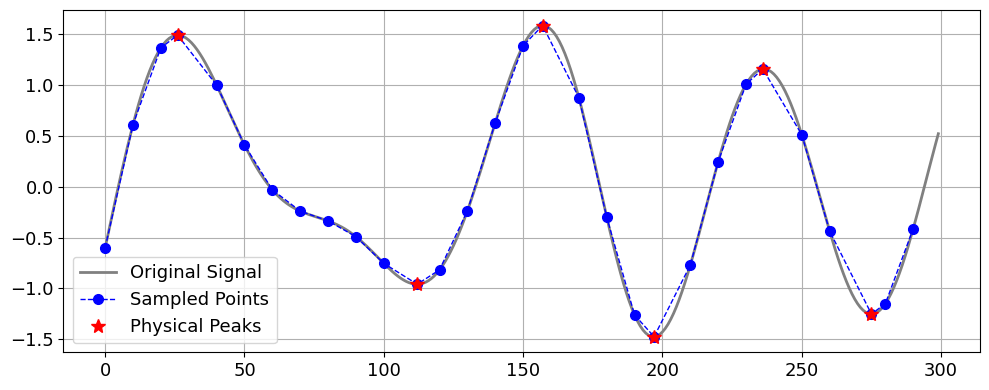

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def visualize_sampling_partial(
    data: np.ndarray,
    sampled_data: np.ndarray,
    sampled_indices: list[int],
    peak_indices: list[int],
    trough_indices: list[int],
    important_indices: list[int],
    start: int = 0,
    end: int = 5000,
    title: str = ""
):
    """Visualize sampled signal with physical peaks and troughs."""
    plt.figure(figsize=(10, 4))

    x = np.arange(len(data))
    view_range = (x >= start) & (x < end)
    x_range = x[view_range] - start  # Shift X-axis to start from 0

    # Plot original signal
    plt.plot(x_range, data[view_range], label="Original Signal", color="gray", linewidth=2)

    # Plot sampled points within view range (dashed blue line)
    sampled_in_range = [(i, data[i]) for i in sampled_indices if start <= i < end]
    if sampled_in_range:
        xs, ys = zip(*sampled_in_range)
        xs = np.array(xs) - start
        plt.plot(xs, ys, 'bo--', label="Sampled Points", markersize=7, linewidth=1)

    # Plot important points (peaks and troughs) as red stars
    important_in_range = [i for i in important_indices if start <= i < end]
    xs_imp = np.array(important_in_range) - start
    ys_imp = data[important_in_range]
    plt.plot(xs_imp, ys_imp, 'r*', label="Physical Peaks", markersize=10)

    # Set layout and formatting
    fontsize = 13
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(True)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

# -----------------------------------------------
# Prepare signal and sampling
# -----------------------------------------------

n = 10  # Sampling interval

# Use file_index 4 from test dataset
test_df_file4 = test_df[test_df["file_index"] == 4].reset_index(drop=True)
signal = test_df_file4["x3(m)"].values[:5000]

# Detect physical peaks and troughs
peak_indices, _ = find_peaks(signal, distance=50)
trough_indices, _ = find_peaks(-signal, distance=50)
important_indices = np.sort(np.concatenate([peak_indices, trough_indices])).tolist()

# Uniform sampling
sampled_indices = list(range(0, len(signal), n))

# Replace closest sampled point with important point to preserve peaks/troughs
for idx in important_indices:
    if idx not in sampled_indices:
        closest = min(sampled_indices, key=lambda x: abs(x - idx))
        sampled_indices.remove(closest)
        sampled_indices.append(idx)

sampled_indices = sorted(sampled_indices)

# Visualize
visualize_sampling_partial(
    data=signal,
    sampled_data=signal[sampled_indices],
    sampled_indices=sampled_indices,
    peak_indices=peak_indices.tolist(),
    trough_indices=trough_indices.tolist(),
    important_indices=important_indices,
    start=1000,
    end=1300,
    title=f"(n={n})"
)


# Model Training

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau  # 추가
from scipy.signal import find_peaks

In [2]:
# ----------------------------
# Model Definitions
# ----------------------------

class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out


class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out


class GRUModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out


class BiLSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out


In [3]:
import torch
from torch.utils.data import Dataset

# ----------------------------------------
# Dataset 1: All DoFs except wave (6DoF)
# ----------------------------------------
class SixDoFDataset(Dataset):
    def __init__(self, data, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.feature_columns = ["x1(m)", "x2(m)", "x3(m)", "x4(deg)", "x5(deg)", "x6(deg)"]
        self.samples = self._create_samples(data)

    def _create_samples(self, data):
        samples = []
        for _, group in data.groupby("file_index"):
            series = group.sort_values("t(s)")[self.feature_columns].values
            max_start = len(series) - (self.input_size + self.output_size)
            for i in range(0, max_start + 1, self.input_size):
                x = series[i:i + self.input_size]
                y = series[i + self.input_size:i + self.input_size + self.output_size]
                samples.append((x, y))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# ----------------------------------------
# Dataset 2: Full input (wave + motion), output excludes wave (6DoF)
# ----------------------------------------
class FullToMotionDataset(Dataset):
    def __init__(self, data, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.wave_column = "z(m)"
        self.feature_columns = [col for col in data.columns if col not in ["t(s)", "file_index"]]
        self.output_columns = [col for col in self.feature_columns if col != self.wave_column]
        self.samples = self._create_samples(data)

    def _create_samples(self, data):
        samples = []
        for _, group in data.groupby("file_index"):
            group = group.sort_values("t(s)")
            x_series = group[self.feature_columns].values
            y_series = group[self.output_columns].values
            max_start = len(group) - (self.input_size + self.output_size)
            for i in range(0, max_start + 1, self.input_size):
                x = x_series[i:i + self.input_size]
                y = y_series[i + self.input_size:i + self.input_size + self.output_size]
                samples.append((x, y))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# ----------------------------------------
# Dataset 3: Wave + Heave → Heave
# ----------------------------------------
class WaveHeaveToHeaveDataset(Dataset):
    def __init__(self, data, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.input_columns = ["z(m)", "x3(m)"]
        self.output_column = "x3(m)"
        self.samples = self._create_samples(data)

    def _create_samples(self, data):
        samples = []
        for _, group in data.groupby("file_index"):
            group = group.sort_values("t(s)")
            x_series = group[self.input_columns].values
            y_series = group[[self.output_column]].values
            max_start = len(group) - (self.input_size + self.output_size)
            for i in range(0, max_start + 1, self.input_size):
                x = x_series[i:i + self.input_size]
                y = y_series[i + self.input_size:i + self.input_size + self.output_size]
                samples.append((x, y))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# ----------------------------------------
# Dataset 4: Heave → Heave (x3 only)
# ----------------------------------------
class HeaveToHeaveDataset(Dataset):
    def __init__(self, data, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.column = "x3(m)"
        self.samples = self._create_samples(data)

    def _create_samples(self, data):
        samples = []
        for _, group in data.groupby("file_index"):
            series = group.sort_values("t(s)")[self.column].values
            max_start = len(series) - (self.input_size + self.output_size)
            for i in range(0, max_start + 1, self.input_size):
                x = series[i:i + self.input_size]
                y = series[i + self.input_size:i + self.input_size + self.output_size]
                samples.append((x, y))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return (
            torch.tensor(x, dtype=torch.float32).unsqueeze(1),
            torch.tensor(y, dtype=torch.float32).unsqueeze(1),
        )


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau

class SixDofLitModel(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)  # show on progress bar
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)  # show on progress bar
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                mode='min',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            ),
            'monitor': 'val_loss',   # monitored metric
            'interval': 'epoch',     # check every epoch
            'frequency': 1
        }
        return [optimizer], [scheduler]


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# 공통 학습 설정
sequence_lengths = [200]
downsample_ratios = [5]
hidden_dims = [64]
num_layers_list = [3, 5, 10, 15, 20]

model_dict = {
    "RNN": RNNModel,
    "LSTM": LSTMModel,
    "GRU": GRUModel,
    "BI-LSTM": BiLSTMModel,
}

BASE_MODEL_DIR = "model/model_tests/6DoF_6DoF"
BASE_LOG_DIR = "logs/model_tests/6DoF_6DoF"

def load_dataset(train_path, val_path, input_size, output_size):
    if not os.path.exists(train_path) or not os.path.exists(val_path):
        return None, None
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)

    if len(train_df) < input_size + output_size or len(val_df) < input_size + output_size:
        return None, None

    train_dataset = SixDoFDataset(train_df, input_size, output_size)
    val_dataset = SixDoFDataset(val_df, input_size, output_size)
    return train_dataset, val_dataset

for model_name, ModelClass in model_dict.items():
    for seq_length in sequence_lengths:
        for n in downsample_ratios:
            for hidden_dim in hidden_dims:
                for num_layers in num_layers_list:

                    suffix = f"{model_name}_seq{seq_length}_n{n}_hd{hidden_dim}_nl{num_layers}"
                    print(f"\n📚 Training {suffix}")

                    input_size = output_size = seq_length // n
                    train_path = f"downsampled_data/Downsampling{n}/train_n{n}.csv"
                    val_path = f"downsampled_data/Downsampling{n}/val_n{n}.csv"

                    train_dataset, val_dataset = load_dataset(train_path, val_path, input_size, output_size)

                    if train_dataset is None or val_dataset is None:
                        print(f"❌ Skipping {suffix} due to missing or insufficient data.")
                        continue

                    if len(train_dataset) < 64 or len(val_dataset) < 64:
                        print(f"⚠️ Too few samples for {suffix}. Skipping.")
                        continue

                    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
                    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=True)

                    input_dim = train_dataset[0][0].shape[-1]
                    output_dim = train_dataset[0][1].shape[-1]

                    model = ModelClass(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)
                    lit_model = SixDofLitModel(model, lr=0.001)

                    model_subdir = os.path.join(BASE_MODEL_DIR, f"layer{num_layers}", f"node{hidden_dim}")
                    log_subdir = os.path.join(BASE_LOG_DIR, f"layer{num_layers}", f"node{hidden_dim}")
                    os.makedirs(model_subdir, exist_ok=True)
                    os.makedirs(log_subdir, exist_ok=True)

                    ckpt_name = f"{model_name}_seq{seq_length}_n{n}"

                    early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
                    checkpoint_callback = ModelCheckpoint(dirpath=model_subdir, filename=ckpt_name, monitor='val_loss', save_top_k=1, mode='min')

                    trainer = Trainer(
                        max_epochs=500,
                        callbacks=[early_stop_callback, checkpoint_callback],
                        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                        devices=1,
                        default_root_dir=log_subdir,
                        log_every_n_steps=10
                    )

                    trainer.fit(lit_model, train_loader, val_loader)

                    print(f"✅ Finished {suffix}")


# Prediction


===== hidden_dim=64, num_layers=2 =====
    ✅ 사용 모델: RNN_seq100_n1.pth
    📂 절대 경로: /home/haeun/time_series/time_series/model/model_tests/waves+6DoF/layer2/node64/RNN_seq100_n1.pth
    ✅ 사용 모델: LSTM_seq100_n1.pth
    📂 절대 경로: /home/haeun/time_series/time_series/model/model_tests/waves+6DoF/layer2/node64/LSTM_seq100_n1.pth
    ✅ 사용 모델: GRU_seq100_n1.pth
    📂 절대 경로: /home/haeun/time_series/time_series/model/model_tests/waves+6DoF/layer2/node64/GRU_seq100_n1.pth
    ✅ 사용 모델: BI-LSTM_seq100_n1.pth
    📂 절대 경로: /home/haeun/time_series/time_series/model/model_tests/waves+6DoF/layer2/node64/BI-LSTM_seq100_n1.pth


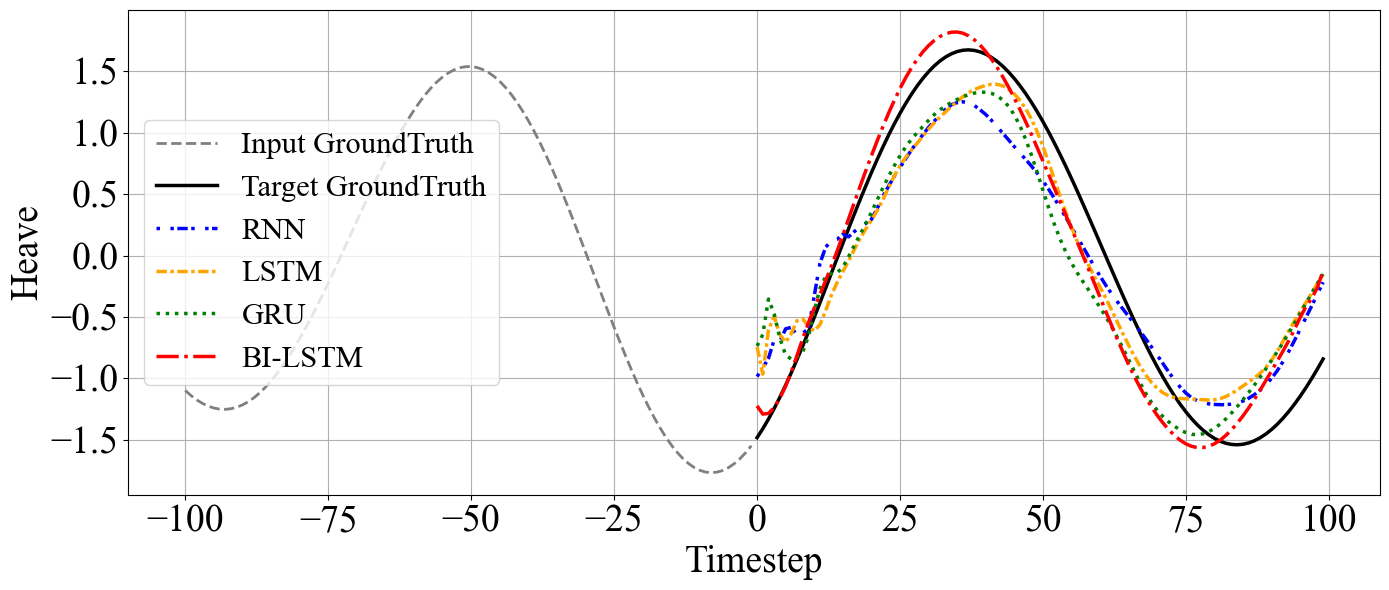

In [ ]:
import os
import glob
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ----------------------------
# Configuration
# ----------------------------
TEST_FILE_INDEX = 4
INPUT_SEQ_LEN = 100
OUTPUT_SEQ_LEN = 100
START_INDEX = 2500

# Select features based on the prediction scenario
SELECTED_COLUMNS = ["x1(m)", "x2(m)", "x3(m)", "x4(deg)", "x5(deg)", "x6(deg)"]
MODEL_DIR = "model/model_tests/6DoF_6DoF"

MODEL_DICT = {
    "RNN": RNNModel,
    "LSTM": LSTMModel,
    "GRU": GRUModel,
    "BI-LSTM": BiLSTMModel,
}

DOWNSAMPLE_RATIOS = [1]
HIDDEN_DIMS = [64]
NUM_LAYERS_LIST = [2]

# ----------------------------
# Find peaks and troughs
# ----------------------------
def find_peak_and_trough_indices_multivariate(df, distance=30):
    indices = set()
    for col in df.columns:
        if col in ["t(s)", "file_index"]:
            continue
        values = df[col].values
        peaks, _ = find_peaks(values, distance=distance)
        troughs, _ = find_peaks(-values, distance=distance)
        indices.update(peaks.tolist())
        indices.update(troughs.tolist())
    return np.sort(list(indices))

# ----------------------------
# Adjusted sampling strategy
# ----------------------------
def get_adjusted_sampled_data(signal, n, important_indices):
    base_indices = np.arange(0, len(signal), n)
    final_indices = set(base_indices.tolist())
    for idx in important_indices:
        if idx not in final_indices:
            closest = min(final_indices, key=lambda x: abs(x - idx))
            final_indices.remove(closest)
            final_indices.add(idx)
    sorted_indices = sorted([i for i in final_indices if i < len(signal)])
    return signal[sorted_indices]

# ----------------------------
# Filter test data
# ----------------------------
test_df = test_df[test_df["file_index"] == TEST_FILE_INDEX].reset_index(drop=True)
important_indices = find_peak_and_trough_indices_multivariate(test_df, distance=30)

# ----------------------------
# Create input and output sequences
# ----------------------------
def prepare_input_output(df, start, input_len, output_len, n):
    input_seq = df.iloc[start:start+input_len][SELECTED_COLUMNS].values.astype(np.float32)
    target_seq = df.iloc[start+input_len:start+input_len+output_len]["x3(m)"].values.astype(np.float32)
    full_time = df.iloc[start+input_len:start+input_len+output_len]["t(s)"].values
    important_local = find_peak_and_trough_indices_multivariate(df.iloc[start:start+input_len])
    down_input = get_adjusted_sampled_data(input_seq, n, important_local)
    down_time = get_adjusted_sampled_data(full_time, n, important_local)
    return torch.tensor(down_input, dtype=torch.float32).unsqueeze(0), target_seq, full_time, down_time

# ----------------------------
# Model inference
# ----------------------------
def predict_heave(model_cls, model_path, input_tensor):
    layer = int(re.search(r"layer(\d+)", model_path).group(1))
    node = int(re.search(r"node(\d+)", model_path).group(1))
    input_dim = 6
    output_dim = 6
    model = model_cls(input_dim, node, layer, output_dim)

    if model_path.endswith(".ckpt"):
        ckpt = torch.load(model_path, map_location="cpu")
        state_dict = {k.replace("model.", ""): v for k, v in ckpt["state_dict"].items()}
        model.load_state_dict(state_dict)
    else:
        model.load_state_dict(torch.load(model_path, map_location="cpu"))

    model.eval()
    with torch.no_grad():
        output = model(input_tensor).squeeze().numpy()
    return output[:, 2] if output.shape[1] > 1 else output

# ----------------------------
# Clean filename
# ----------------------------
def clean_ckpt_filename(filename):
    filename = filename.replace(".ckpt", "").replace(".pth", "")
    return re.sub(r"-epoch=\d+-val_loss=[\d\.]+", "", filename)

# ----------------------------
# Visualization
# ----------------------------
def visualize_predictions_with_input(input_gt, target_seq, hidden_dim, num_layers, model_predictions):
    plt.figure(figsize=(14, 6))
    styles = {
        "Input Ground Truth": ("gray", "--", 2),
        "Target Ground Truth": ("black", "-", 2.5),
        "RNN": ("blue", (0, (1, 3, 1)), 2.5),
        "LSTM": ("orange", (0, (3, 1, 1, 1)), 2.5),
        "GRU": ("green", ":", 2.5),
        "BI-LSTM": ("red", "-.", 2.5),
    }

    t_input = np.arange(-len(input_gt), 0)
    t_target = np.arange(0, len(target_seq))

    plt.plot(t_input, input_gt, label="Input GroundTruth", color=styles["Input Ground Truth"][0], linestyle=styles["Input Ground Truth"][1], linewidth=styles["Input Ground Truth"][2])
    plt.plot(t_target, target_seq, label="Target GroundTruth", color=styles["Target Ground Truth"][0], linestyle=styles["Target Ground Truth"][1], linewidth=styles["Target Ground Truth"][2])

    for label, (pred, t_pred) in model_predictions.items():
        model_name = label.split("_")[0]
        color, style, width = styles.get(model_name, ("gray", "-", 2.5))
        plt.plot(t_pred, pred, color=color, linestyle=style, linewidth=width, label=label)

    fontsize = 27
    plt.xlabel("Timestep", fontsize=fontsize)
    plt.ylabel("Heave", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(True)
    plt.legend(loc="center left", fontsize=fontsize-5)
    plt.tight_layout()
    plt.show()

# ----------------------------
# Run inference and plot
# ----------------------------
for hidden_dim in HIDDEN_DIMS:
    for num_layers in NUM_LAYERS_LIST:
        print(f"\n===== hidden_dim={hidden_dim}, num_layers={num_layers} =====")
        model_predictions = {}
        input_gt = test_df.iloc[START_INDEX:START_INDEX+INPUT_SEQ_LEN]["x3(m)"].values.astype(np.float32)

        for model_name, cls in MODEL_DICT.items():
            for n in DOWNSAMPLE_RATIOS:
                input_tensor, target_seq, time_seq, _ = prepare_input_output(test_df, START_INDEX, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN, n)
                suffix = f"{model_name}_seq{INPUT_SEQ_LEN}_n{n}"
                model_path = os.path.join(MODEL_DIR, f"layer{num_layers}", f"node{hidden_dim}", f"{suffix}.ckpt")

                if not os.path.exists(model_path):
                    print(f"    ❌ Not found: {model_path}")
                    continue

                print(f"    ✅ Loaded: {os.path.abspath(model_path)}")
                pred = predict_heave(cls, model_path, input_tensor)
                time_pred = np.arange(0, len(pred) * n, n)
                model_predictions[model_name] = (pred, time_pred)

        if model_predictions:
            visualize_predictions_with_input(input_gt, target_seq, hidden_dim, num_layers, model_predictions)